In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters Initialisaton

lambda_ = np.log(2) / 5  # Mean-reversion rate (half-life = 5)
sigma = 0.1              # Volatility
pe = 50                  # Equilibrium price
tickSize = 0.1
lotSize = 1
K = 5                    # Max trade size
M = 10                   # Max position size
kappa = 0.01             # Risk aversion
alpha = 0.003           # Learning rate
gamma = 0.999            # Discount factor
epsilon = 0.1            # Exploration rate
nTrain = (10**7)
decayFactor = 0.999

In [3]:
# action and state space
actionSpace = np.arange(-K, K + 1)
positionSpace = np.arange(-M, M + 1)
priceSpace = np.round(np.arange(1, 1001) * tickSize, 1)

stateSpace = [(p, n) for p in priceSpace for n in positionSpace]
stateIndex = {s: i for i, s in enumerate(stateSpace)}
#((pt,nt-1),action)



In [4]:
# Q-matrix Initialisation
Q = np.zeros((len(stateSpace), len(actionSpace)))
Q = np.random.uniform(low=-1, high=1, size=(len(stateSpace), len(actionSpace)))

for i, state in enumerate(stateSpace):
    pt, nt = state
    for j, action in enumerate(actionSpace):
        if nt + action > M or nt + action < -M:
            Q[i, j] = -np.inf

In [5]:
# Simulation of Ornstein-Uhlenbeck price process
def simulatePrice(pt, dt=1):
    xt = np.log(pt / pe)
    dxt = -lambda_ * xt + sigma * np.random.normal(0,1)
    xt_next = xt + dxt * dt
    pt_next = pe * np.exp(xt_next)
    return max(tickSize, min(pt_next, 100))

def simulatePriceWithNoise(pt, dt=1):
    xt = np.log(pt / pe)
    dxt = -lambda_ * xt + sigma * np.random.normal(0, 1)
    xt_next = xt + dxt * dt
    pt_next = pe * np.exp(xt_next)
    noise = 0
    if np.random.rand() > 0.3:
        noise = min(100-pt,pt) * np.random.uniform(-0.2, 0.2)
    pt_next += noise
    return max(tickSize, min(pt_next, 100))

# Trading costs
def spreadCost(deltaN):
    return tickSize * abs(deltaN) / 100

def impactCost(deltaN):
    return ((deltaN * lotSize) ** 2) * tickSize / lotSize / 10000

def totalCost(deltaN):
    return spreadCost(deltaN) + impactCost(deltaN)

# reward Calculation for training

def reward(pt, pt_next, deltaN, nt,timeHeld):
    pnl = ((nt + deltaN) * lotSize) * (pt_next - pt)
    cost = totalCost(deltaN)
    timePenalty = timeHeld * 0.01
    totalReward = pnl  - cost - 0.5 * kappa * ((pnl) ** 2)
    # print(totalReward, pnl)
    return totalReward

# reward Calculation for testing
def rewardeval(pt, pt_next, deltaN, nt):
    pnl = ((nt + deltaN) * lotSize) * (pt_next - pt)
    # pnl = ((nt + deltaN) * lotSize) * (pt_next - np.random.uniform(0.2, 1.5) - pt - np.random.uniform(0.2, 1.5))
    cost = totalCost(deltaN)
    return pnl - cost

def rewardevalBidAsk(pt, pt_next, deltaN, nt):
    # pnl = ((nt + deltaN) * lotSize) * (pt_next - pt)
    pnl = ((nt + deltaN) * lotSize) * (pt_next - np.random.uniform(0.2, 1.5) - pt - np.random.uniform(0.2, 1.5))
    cost = totalCost(deltaN)
    return pnl - cost

In [6]:
# Q-learning update
def qLearningUpdate(state, action, reward, next_state):
    stateIdx = stateIndex.get(state, None)
    if stateIdx is None:
        return
    actionIdx = np.where(actionSpace == action)[0][0]

    next_stateIdx = stateIndex.get(next_state, None)
    if next_stateIdx is None:
        return

    max_q_next = np.max(Q[next_stateIdx])
    Q[stateIdx, actionIdx] += alpha * (reward + gamma * max_q_next - Q[stateIdx, actionIdx])

# Discretization functions
def discretPrice(pt):
    return round(pt,1)

def discretPosition(nt):
    return round(nt)

In [7]:
# Training loop

pt = 50
nt = 0
epsilonInitial = 1.0
epsilonFinal = 0.1
epsilonDecay = 0.99998
epsilon = epsilonInitial
timeheld = 0
for step in range(nTrain):
    pt = discretPrice(pt)
    nt = discretPosition(nt)

    epsilon = max(epsilonFinal, epsilon * epsilonDecay)
    if np.random.rand() < epsilon:  # exploration
        validActions = [a for a in actionSpace if abs(a + nt) <= M]
        action = np.random.choice(validActions)
    else:  #exploitation
        stateIdx = stateIndex.get((pt, nt), None)
        validActions = [a for a in actionSpace if abs(a + nt) <= M]
        if validActions:
            valid_q_values = [Q[stateIdx][action] for action in validActions]
            action = validActions[np.argmax(valid_q_values)]

    if action == 0:
        timeheld += 1
    else:
        timeheld = 0
    deltaN = action
    pt_next = simulatePrice(pt)
    nt_next = nt + deltaN
    pt_next = discretPrice(pt_next)
    nt_next = discretPosition(nt_next)

    if pt_next < 0.1 or pt_next > 100 or nt_next < -M or nt_next > M:
      pt_next = np.clip(pt_next, 0.1, 100)
      nt_next = np.clip(nt_next, -M, M)
      print(step, pt, nt, pt_next, nt_next)

    rt = reward(pt, pt_next, deltaN, nt, timeheld)

    qLearningUpdate((pt, nt), deltaN, rt, (pt_next, nt_next))
    # Q*=decayFactor
    pt, nt = pt_next, nt_next

In [31]:
# Testing
cumulativePnl = []
totalPnl = 0
priceList = []
pt = 50
nt = 0
alpha = 0.001
timeheld = 0
actionCounter = {action: 0 for action in actionSpace}

for _ in range(5000):
    pt = discretPrice(pt)
    nt = discretPosition(nt)

    stateIdx = stateIndex.get((pt, nt), None)
    if stateIdx is None:
        continue

    action = actionSpace[np.argmax(Q[stateIdx])]
    deltaN = action
    actionCounter[action] += 1
    if action == 0:
        timeheld += 1
    else:
        timeheld = 0
    pt_next = simulatePrice(pt)
    nt_next = nt + deltaN
    pt_next = discretPrice(pt_next)
    nt_next = discretPosition(nt_next)

    if pt_next < 1 or pt_next > 1000 or nt_next < -M * lotSize or nt_next > M * lotSize:
        continue
    priceList.append(pt_next)
    rteval = rewardeval(pt, pt_next, deltaN,nt)
    totalPnl+= rteval
    cumulativePnl.append(totalPnl)

    rt = reward(pt, pt_next, deltaN,nt,timeheld)
    next_stateIdx = stateIndex.get((pt_next, nt_next), None)

    if next_stateIdx is not None:
        max_qNext = np.max(Q[next_stateIdx])
        Q[stateIdx, np.where(actionSpace == deltaN)[0][0]] += alpha * (rt + gamma * max_qNext - Q[stateIdx, np.where(actionSpace == deltaN)[0][0]])
    pt, nt = pt_next, nt_next


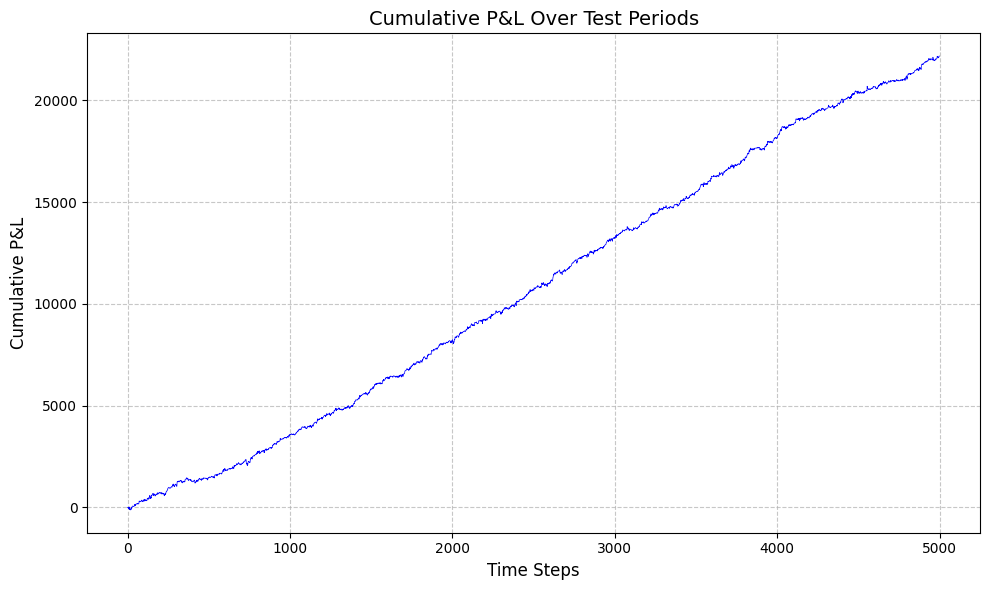

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(cumulativePnl)), cumulativePnl, linestyle='-', color='b', linewidth=0.5)  # Thinner line

plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Cumulative P&L", fontsize=12)
plt.title("Cumulative P&L Over Test Periods", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

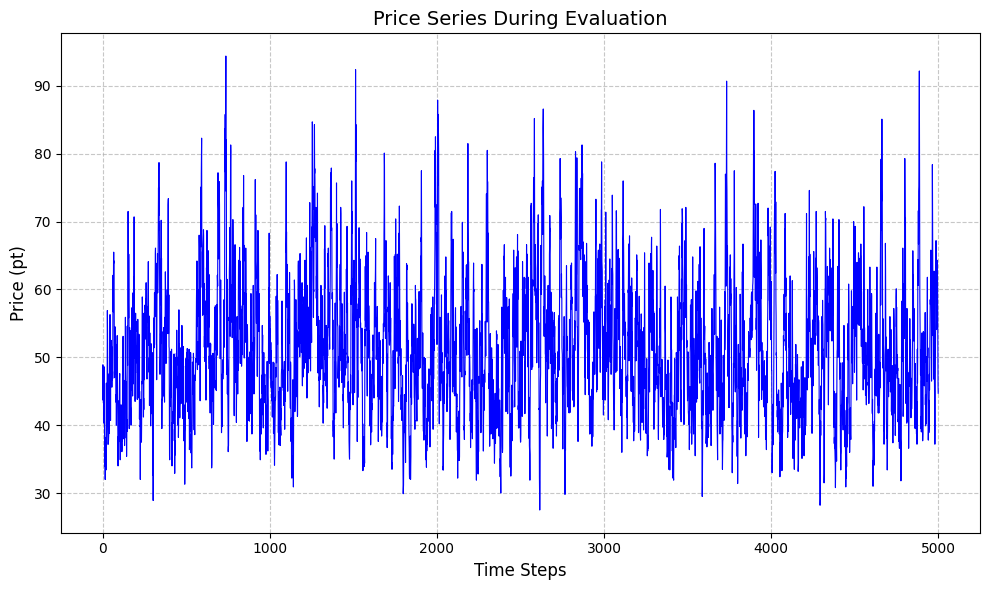

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(priceList, linestyle='-', color='b', linewidth=0.8)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Price (pt)", fontsize=12)
plt.title("Price Series During Evaluation", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
# Testing with noise and Bid Ask
cumulativePnl = []
totalPnl = 0
priceList = []
pt = 50
nt = 0
alpha = 0.0008
timeheld = 0
actionCounter = {action: 0 for action in actionSpace}
for _ in range(5000):
    pt = discretPrice(pt)
    nt = discretPosition(nt)

    stateIdx = stateIndex.get((pt, nt), None)
    if stateIdx is None:
        continue

    action = actionSpace[np.argmax(Q[stateIdx])]
    deltaN = action
    actionCounter[action] += 1
    if action == 0:
        timeheld += 1
    else:
        timeheld = 0
    pt_next = simulatePriceWithNoise(pt)
    nt_next = nt + deltaN
    pt_next = discretPrice(pt_next)
    nt_next = discretPosition(nt_next)

    if pt_next < 1 or pt_next > 1000 or nt_next < -M * lotSize or nt_next > M * lotSize:
        continue
    priceList.append(pt_next)
    rteval = rewardevalBidAsk(pt, pt_next, deltaN,nt)
    totalPnl+= rteval
    cumulativePnl.append(totalPnl)

    rt = reward(pt, pt_next, deltaN,nt,timeheld)
    # rt = rteval
    next_stateIdx = stateIndex.get((pt_next, nt_next), None)

    if next_stateIdx is not None:
        max_qNext = np.max(Q[next_stateIdx])
        Q[stateIdx, np.where(actionSpace == deltaN)[0][0]] += alpha * (rt + gamma * max_qNext - Q[stateIdx, np.where(actionSpace == deltaN)[0][0]])
    pt, nt = pt_next, nt_next


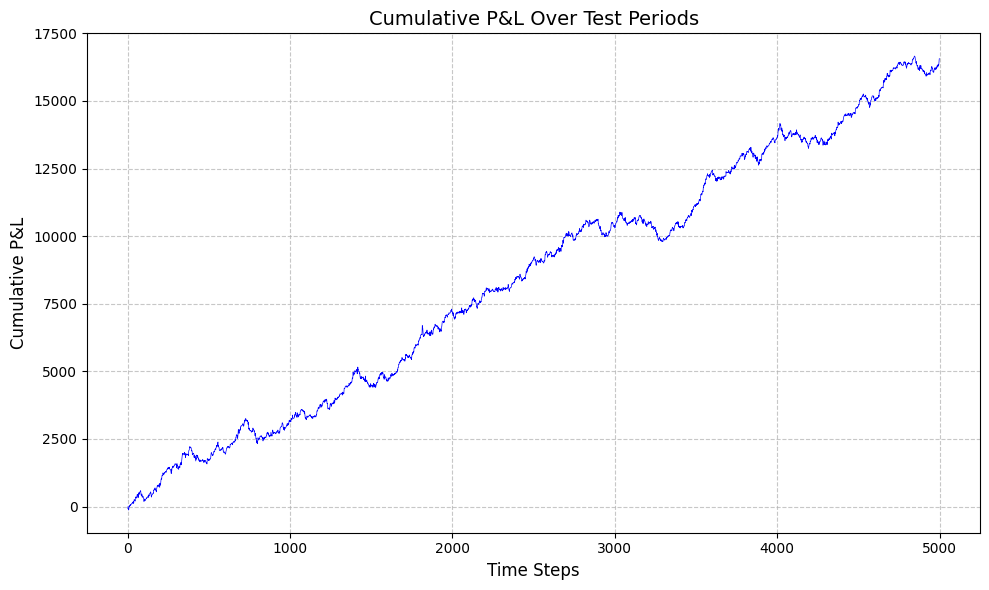

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(cumulativePnl)), cumulativePnl, linestyle='-', color='b', linewidth=0.5)  # Thinner line

plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Cumulative P&L", fontsize=12)
plt.title("Cumulative P&L Over Test Periods", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

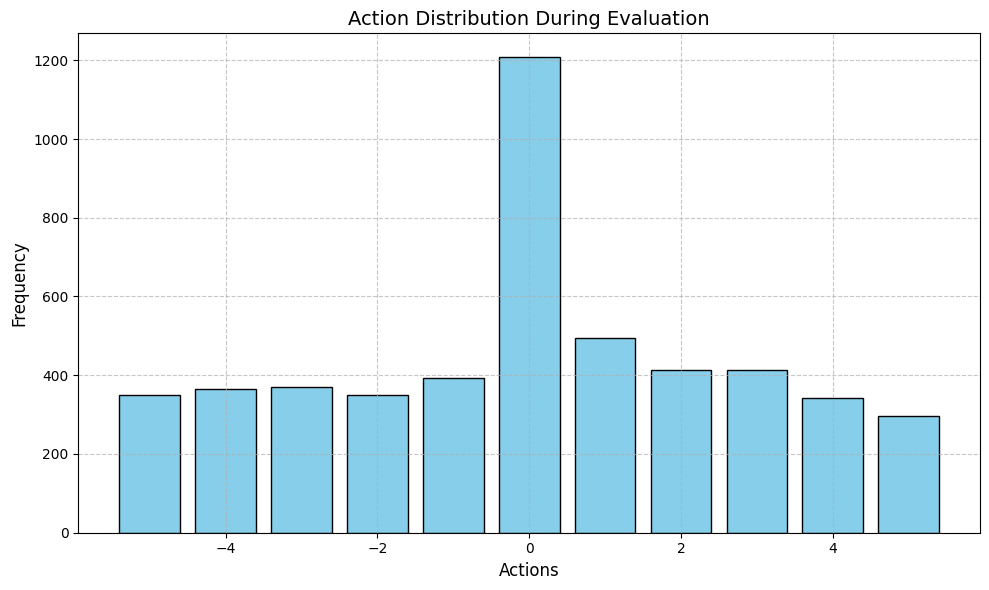

In [13]:
# Plot action distribution
plt.figure(figsize=(10, 6))
plt.bar(actionCounter.keys(), actionCounter.values(), color='skyblue', edgecolor='black')
plt.xlabel("Actions", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Action Distribution During Evaluation", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [36]:
Q[:20]

array([[       -inf,        -inf,        -inf,        -inf,        -inf,
        -0.05022045, -0.54443842, -0.29698832, -0.46866833,  0.7469894 ,
        -0.17841526],
       [       -inf,        -inf,        -inf,        -inf, -0.6333592 ,
        -0.64105253,  0.61650207, -0.36994432, -0.28925849,  0.1038064 ,
         0.91562156],
       [       -inf,        -inf,        -inf,  0.85482486, -0.75610527,
         0.84029413,  0.24960777, -0.83266506, -0.79606636,  0.52326761,
         0.28431103],
       [       -inf,        -inf,  0.79688113, -0.70631412, -0.01473622,
        -0.79413228,  0.9211929 ,  0.10515624, -0.01375253,  0.37704852,
         0.61582539],
       [       -inf, -0.02151238, -0.71241377, -0.98973971, -0.01484725,
        -0.3406486 , -0.70881271,  0.78438315, -0.74321846, -0.94226729,
         0.6518496 ],
       [ 0.76617361,  0.72011414, -0.50845498,  0.60407052,  0.38067847,
         0.88704576,  0.55999532,  0.13543627, -0.07762277,  0.32478859,
        -0.496